In [1]:
import sys

sys.path.append("..")

In [2]:
import random

import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib

from src.util import *
from src.model import *

tqdm.pandas()

In [3]:
last_review_date = pd.to_datetime("2015/01/01")
train_split_date = pd.to_datetime("2017/01/01")
test_split_date = pd.to_datetime("2018/01/01")

seed = 0
random.seed(seed)
np.random.seed(seed)

In [4]:
interaction_df, user_le, item_le = load_interaction_df(
    last_review_date=last_review_date,
    train_split_date=train_split_date,
)
items = item_le.transform(item_le.classes_)

(
    train_dataset,
    test_dataset,
    train_user_feature_table,
    test_user_feature_table,
) = create_dataset(
    interaction_df=interaction_df,
    train_split_date=train_split_date,
    test_split_date=test_split_date,
)

100%|██████████| 25093/25093 [00:00<00:00, 235019.64it/s]


In [5]:
class Model2(torch.nn.Module):
    def __init__(
        self,
        item_size: int,
        user_feature_dim: int,
        num_layers: int = 4,
        d_model: int = 64,
        dim_feedforward: int = 128,
        nhead: int = 4,
    ) -> None:
        super().__init__()
        self.user_embedding = torch.nn.Linear(user_feature_dim, d_model)
        self.item_embedding = torch.nn.Embedding(item_size, d_model)

        self.transformer_layer = torch.nn.TransformerEncoder(
            encoder_layer=torch.nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                batch_first=True,
            ),
            num_layers=num_layers,
        )
        self.clv_layer = TwoFeedForwardLayer(d_model, d_model // 2, 1)
        self.target_layer = TwoFeedForwardLayer(d_model, d_model // 2, d_model)

    def forward(
        self,
        user_features: torch.Tensor,
        item_indices: torch.Tensor,
        target_indices: torch.Tensor,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        e_u = self.user_embedding.forward(user_features)
        e_v = self.item_embedding.forward(item_indices)
        H = torch.cat((e_u.unsqueeze(1), e_v), dim=1)
        H = self.transformer_layer.forward(H)

        y_clv = torch.sigmoid(self.clv_layer.forward(H[:, 0]))
        H_v = self.target_layer.forward(H[:, 1:].sum(dim=-2))

        e_target = self.item_embedding.forward(target_indices)
        v_target = torch.matmul(H_v.unsqueeze(1), e_target.mT)
        y_target = torch.sigmoid(v_target)

        return y_clv.squeeze(), y_target.squeeze()

In [8]:
def run_one_round(
    model: Model2,
    dataloader: torch.utils.data.DataLoader,
    user_feature_table: np.ndarray,
    optimizer: torch.optim.Optimizer,
    args: Args,
    items: list[int],
    is_eval: bool = False,
) -> dict:
    result: dict[str, dict] = {
        "target": {"loss": 0.0, "y_pred": [], "y_true": []},
        "clv": {"loss": 0.0, "y_pred": [], "y_true": []},
    }

    if is_eval:
        model.eval()
    else:
        model.train()

    for batch in tqdm(dataloader):
        user_ids = []
        item_indices = []
        target_indices = []
        target_labels = []
        clv_labels = []

        for (user_id, user_context_items), target_items, clv in batch:
            for _ in range(args.sample_size):
                context_items = []
                for _ in range(args.context_item_size):
                    context_items.append(
                        user_context_items[random.randrange(len(user_context_items))]
                    )

                user_ids.append(user_id)
                item_indices.append(context_items)
                clv_labels.append(clv)
                target_indices.append([])
                target_labels.append([])

                # 正例
                for _ in range(min(args.negative_sample_size, len(target_items))):
                    target_indices[-1].append(target_items[random.randrange(0, len(target_items))])
                    target_labels[-1].append(1)

                # 負例
                while len(target_indices[-1]) < args.negative_sample_size * 2:
                    target_indices[-1].append(items[random.randrange(len(items))])
                    target_labels[-1].append(0)

        user_features = torch.FloatTensor(user_feature_table[user_ids]).to(args.device)
        item_indices = torch.LongTensor(item_indices).to(args.device)
        target_indices = torch.LongTensor(target_indices).to(args.device)
        target_labels = torch.FloatTensor(target_labels).to(args.device).flatten()
        clv_labels = torch.FloatTensor(clv_labels).to(args.device).flatten()

        y_clv, y_target = model.forward(user_features, item_indices, target_indices)
        y_clv = y_clv.flatten()
        y_target = y_target.flatten()

        target_loss = torch.nn.functional.binary_cross_entropy(y_target, target_labels)
        clv_loss = torch.nn.functional.binary_cross_entropy(y_clv, clv_labels)
        loss = target_loss * args.alpha + clv_loss * (1 - args.alpha)

        if not is_eval:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        result["target"]["loss"] += target_loss.item()
        result["target"]["y_pred"].extend(y_target.tolist())
        result["target"]["y_true"].extend(target_labels.tolist())
        result["clv"]["loss"] += clv_loss.item()
        result["clv"]["y_pred"].extend(y_clv.tolist())
        result["clv"]["y_true"].extend(clv_labels.tolist())

    for term_name in result.keys():
        result[term_name]["loss"] /= len(dataloader)

    return result


def train(
    model: Model2,
    train_dataset: Dataset,
    test_dataset: Dataset,
    train_user_feature_table: np.ndarray,
    test_user_feature_table: np.ndarray,
    args: Args,
    items: list[int],
) -> tuple[list[dict], list[dict]]:
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        collate_fn=lambda x: x,  # 各データは形式が異なるため、バッチ化せずにそのまま返す
    )
    test_dataloader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=lambda x: x,  # 各データは形式が異なるため、バッチ化せずにそのまま返す
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    train_results = []
    test_results = []

    for epoch in range(args.epochs):
        print(f"[epoch: {epoch + 1}/{args.epochs}]")
        train_result = run_one_round(
            model=model,
            dataloader=train_dataloader,
            user_feature_table=train_user_feature_table,
            optimizer=optimizer,
            args=args,
            items=items,
        )
        print(
            f"[train][loss] target_loss: {train_result['target']['loss']:.6f}, clv_loss: {train_result['clv']['loss']:.6f}"
        )
        train_results.append(train_result)

        test_result = run_one_round(
            model=model,
            dataloader=test_dataloader,
            user_feature_table=test_user_feature_table,
            optimizer=optimizer,
            args=args,
            items=items,
            is_eval=True,
        )
        print(
            f"[test][loss] target_loss: {test_result['target']['loss']:.6f}, clv_loss: {test_result['clv']['loss']:.6f}"
        )
        test_results.append(test_result)

    return train_results, test_results

In [9]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

target_loss_weight = 1
clv_loss_weight = 1
alpha = target_loss_weight / (target_loss_weight + clv_loss_weight)

args = Args(
    d_model=32,
    batch_size=64,
    nhead=4,
    epochs=20,
    lr=1e-3,
    sample_size=5,
    negative_sample_size=5,
    alpha=alpha,
    context_item_size=10,
    device=device,
    model_path="model2.model",
)

try:
    model = torch.load(args.model_path)
    print(f"loaded model from: {args.model_path}")
except FileNotFoundError:
    model = Model2(
        item_size=len(items),
        user_feature_dim=train_user_feature_table.shape[1],
        d_model=args.d_model,
        nhead=args.nhead,
    )
model.to(args.device)
model.train()

print(f"args: {args}")
train_results, test_results = train(
    model=model,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    train_user_feature_table=train_user_feature_table,
    test_user_feature_table=test_user_feature_table,
    args=args,
    items=items,
)

torch.save(model, args.model_path)
print(f"saved model to: {args.model_path}")

args: Args(d_model=32, batch_size=64, nhead=4, epochs=20, lr=0.001, sample_size=5, negative_sample_size=5, alpha=0.5, context_item_size=10, device='mps', model_path='model2.model')
[epoch: 1/20]


100%|██████████| 393/393 [00:18<00:00, 21.80it/s]


[train][loss] target_loss: 0.712190, clv_loss: 0.351043


100%|██████████| 393/393 [00:06<00:00, 62.55it/s]


[test][loss] target_loss: 0.645850, clv_loss: 0.308381
[epoch: 2/20]


100%|██████████| 393/393 [00:17<00:00, 22.67it/s]


[train][loss] target_loss: 0.550426, clv_loss: 0.305824


100%|██████████| 393/393 [00:06<00:00, 64.05it/s]


[test][loss] target_loss: 0.457107, clv_loss: 0.305691
[epoch: 3/20]


100%|██████████| 393/393 [00:17<00:00, 22.01it/s]


[train][loss] target_loss: 0.334677, clv_loss: 0.302856


100%|██████████| 393/393 [00:06<00:00, 64.77it/s]


[test][loss] target_loss: 0.292278, clv_loss: 0.311790
[epoch: 4/20]


100%|██████████| 393/393 [00:17<00:00, 22.36it/s]


[train][loss] target_loss: 0.202819, clv_loss: 0.300689


100%|██████████| 393/393 [00:06<00:00, 62.11it/s]


[test][loss] target_loss: 0.230288, clv_loss: 0.300744
[epoch: 5/20]


100%|██████████| 393/393 [00:17<00:00, 22.32it/s]


[train][loss] target_loss: 0.152325, clv_loss: 0.299791


100%|██████████| 393/393 [00:06<00:00, 63.11it/s]


[test][loss] target_loss: 0.211833, clv_loss: 0.300994
[epoch: 6/20]


100%|██████████| 393/393 [00:17<00:00, 22.27it/s]


[train][loss] target_loss: 0.135626, clv_loss: 0.298615


100%|██████████| 393/393 [00:06<00:00, 61.71it/s]


[test][loss] target_loss: 0.205858, clv_loss: 0.298369
[epoch: 7/20]


100%|██████████| 393/393 [00:17<00:00, 22.61it/s]


[train][loss] target_loss: 0.127901, clv_loss: 0.298115


100%|██████████| 393/393 [00:06<00:00, 63.94it/s]


[test][loss] target_loss: 0.205095, clv_loss: 0.303712
[epoch: 8/20]


100%|██████████| 393/393 [00:17<00:00, 22.54it/s]


[train][loss] target_loss: 0.124027, clv_loss: 0.295275


100%|██████████| 393/393 [00:06<00:00, 61.94it/s]


[test][loss] target_loss: 0.205627, clv_loss: 0.296251
[epoch: 9/20]


100%|██████████| 393/393 [00:17<00:00, 22.63it/s]


[train][loss] target_loss: 0.121891, clv_loss: 0.293900


100%|██████████| 393/393 [00:06<00:00, 65.35it/s]


[test][loss] target_loss: 0.207019, clv_loss: 0.299349
[epoch: 10/20]


100%|██████████| 393/393 [00:17<00:00, 22.70it/s]


[train][loss] target_loss: 0.120420, clv_loss: 0.291959


100%|██████████| 393/393 [00:06<00:00, 63.56it/s]


[test][loss] target_loss: 0.204869, clv_loss: 0.296489
[epoch: 11/20]


100%|██████████| 393/393 [00:17<00:00, 22.19it/s]


[train][loss] target_loss: 0.119225, clv_loss: 0.291380


100%|██████████| 393/393 [00:06<00:00, 61.76it/s]


[test][loss] target_loss: 0.205985, clv_loss: 0.302114
[epoch: 12/20]


100%|██████████| 393/393 [00:17<00:00, 22.65it/s]


[train][loss] target_loss: 0.119126, clv_loss: 0.289365


100%|██████████| 393/393 [00:06<00:00, 64.44it/s]


[test][loss] target_loss: 0.207060, clv_loss: 0.297153
[epoch: 13/20]


100%|██████████| 393/393 [00:17<00:00, 22.06it/s]


[train][loss] target_loss: 0.117807, clv_loss: 0.290027


100%|██████████| 393/393 [00:06<00:00, 62.60it/s]


[test][loss] target_loss: 0.208656, clv_loss: 0.297552
[epoch: 14/20]


100%|██████████| 393/393 [00:17<00:00, 22.70it/s]


[train][loss] target_loss: 0.117605, clv_loss: 0.287781


100%|██████████| 393/393 [00:06<00:00, 64.73it/s]


[test][loss] target_loss: 0.209755, clv_loss: 0.300491
[epoch: 15/20]


100%|██████████| 393/393 [00:17<00:00, 22.74it/s]


[train][loss] target_loss: 0.117028, clv_loss: 0.286372


100%|██████████| 393/393 [00:06<00:00, 59.28it/s]


[test][loss] target_loss: 0.210833, clv_loss: 0.300559
[epoch: 16/20]


100%|██████████| 393/393 [00:17<00:00, 22.64it/s]


[train][loss] target_loss: 0.116664, clv_loss: 0.286697


100%|██████████| 393/393 [00:06<00:00, 62.51it/s]


[test][loss] target_loss: 0.213077, clv_loss: 0.303086
[epoch: 17/20]


100%|██████████| 393/393 [00:17<00:00, 22.56it/s]


[train][loss] target_loss: 0.116175, clv_loss: 0.287855


100%|██████████| 393/393 [00:06<00:00, 63.51it/s]


[test][loss] target_loss: 0.212560, clv_loss: 0.299029
[epoch: 18/20]


100%|██████████| 393/393 [00:17<00:00, 22.17it/s]


[train][loss] target_loss: 0.115937, clv_loss: 0.284452


100%|██████████| 393/393 [00:06<00:00, 63.50it/s]


[test][loss] target_loss: 0.214750, clv_loss: 0.300059
[epoch: 19/20]


100%|██████████| 393/393 [00:17<00:00, 22.75it/s]


[train][loss] target_loss: 0.116463, clv_loss: 0.283874


100%|██████████| 393/393 [00:06<00:00, 64.12it/s]


[test][loss] target_loss: 0.215786, clv_loss: 0.315095
[epoch: 20/20]


100%|██████████| 393/393 [00:17<00:00, 21.96it/s]


[train][loss] target_loss: 0.116421, clv_loss: 0.283059


100%|██████████| 393/393 [00:06<00:00, 63.43it/s]

[test][loss] target_loss: 0.217015, clv_loss: 0.302794
saved model to: model2.model


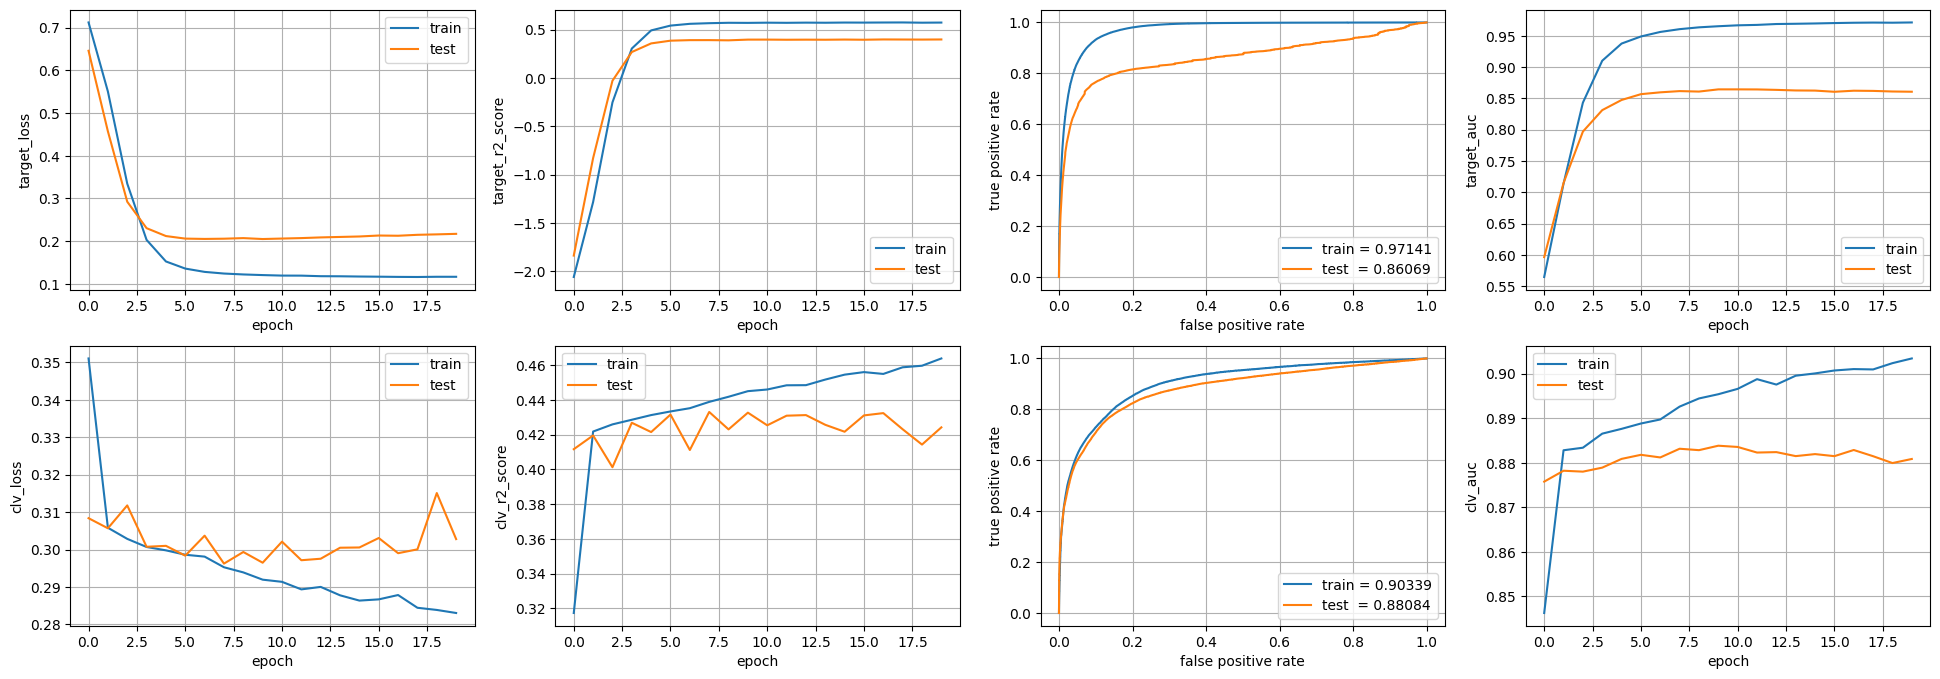

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24, 8))
loss_names = ["target", "clv"]

for i, loss_name in enumerate(loss_names):
    plot_loss(train_results, test_results, loss_name, axes[i, 0])
    plot_r2_score(train_results, test_results, loss_name, axes[i, 1])
    plot_roc_auc(train_results[-1], test_results[-1], loss_name, axes[i, 2])
    plot_auc(train_results, test_results, loss_name, axes[i, 3])

plt.show()

In [ ]:
model.eval()

filter_sample_size = 100
sample_size = 100
top_k = 10

total_count = 0
before_hit_count = 0
after_hit_count = 0

for (user_id, user_context_items), target_items, clv in tqdm(test_dataset):
    if len(target_items) == 0:
        continue

    user_ids = []
    item_indices = []
    for _ in range(filter_sample_size):
        context_items = []
        for _ in range(args.context_item_size):
            context_items.append(user_context_items[random.randrange(len(user_context_items))])
        user_ids.append(user_id)
        item_indices.append(context_items)

    user_features = torch.FloatTensor(test_user_feature_table[user_ids]).to(args.device)
    item_indices = torch.LongTensor(item_indices).to(args.device)
    target_indices = torch.LongTensor(items).to(args.device)

    with torch.no_grad():
        y_clv, y_target = model.forward(user_features, item_indices, target_indices=target_indices)

    b = y_target.mean(dim=0).cpu().detach().numpy()
    filtered_items = items[np.argsort(b)][::-1][:20] # 降順でソートし、上位100件を取得する
    hit = len(set(filtered_items[:top_k]) & set(target_items))
    # print("before rerank:", hit, "/", len(target_items))

    total_count += 1
    if hit > 0:
        before_hit_count += 1

    clv_sum = []
    for item in filtered_items:
        user_ids = []
        item_indices = []

        for _ in range(sample_size):
            context_items = []
            for _ in range(args.context_item_size - 1):
                context_items.append(user_context_items[random.randrange(len(user_context_items))])

            v = list(context_items)
            v.append(item)
            user_ids.append(user_id)
            item_indices.append(v)

        user_features = torch.FloatTensor(test_user_feature_table[user_ids]).to(args.device)
        item_indices = torch.LongTensor(item_indices).to(args.device)
        target_indices = torch.LongTensor([0]).to(args.device) # CLVのみを計算するので、ダミーを入れておく

        with torch.no_grad():
            y_clv, y_target = model.forward(user_features, item_indices, target_indices)

        clv_sum.append(y_clv.mean().item())

    recommendation = filtered_items[np.argsort(clv_sum)][::-1]
    hit = len(set(recommendation[:top_k]) & set(target_items))
    # print("after rerank:", hit, "/", len(target_items))
    if hit > 0:
        after_hit_count += 1

print(f"before HR:  {before_hit_count / total_count:.5f}")
print(f"after HR:   {after_hit_count / total_count:.5f}")

before HR:  0.48786
after HR:   0.52797
